## Examples of how to calculate eigenvalues and condition numbers for both the Orr-Sommerfeld equation and the coupled Orr-Sommerfeld and induction equations

This Jupyter notebook provides basic information on how to start working with the provided code. First, we will demonstrate how to calculate the eigenvalues for different values of N, followed by the computation of condition numbers and the production of corresponding plots. To begin the simulations, please ensure you have at least version 4.1.1 of Shenfun (more information available here: https://github.com/spectralDNS/shenfun).

In [1]:
from shenfun import *
import numpy as np
from OrrSommerfeld_eigs import OrrSommerfeld
from OrrSommerfeldMHD_eigs import OrrSommerfeldMHD
import matplotlib.colors as mcolors
from collections import OrderedDict
np.seterr(divide='ignore')
try:
    from matplotlib import pyplot as plt
except ImportError:
    warnings.warn("matplotlib not installed")

In [2]:
markers=['dashed','solid','densely dotted', 'dashdotted']
linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('densely dotted',      (0, (1, 1))),
     ('dashed',              (0, (5, 5))),
     ('dashdotted',          (0, (3, 5, 1, 5)))])

We have imported the necessary modules, `OrrSommerfeld` for the Orr-Sommerfeld eigenvalue-egenvector problem and `OrrSommerfelMHD` for the corresponding problem with an additional induction equation. Firstly, we look at the eigenvalues for different N.

In [6]:
args = {'N': 120, # Number of discretization points
        'Re': 8000.0, # Reynolds number
        'alfa': 1.0, # Wavenumber
        'quad': 'GC', # Choose from ('GC', 'GL', 'LG') for Gauss-Chebyshev, Gauss-Lobatto, Lobatto-Gauss
        'test': 'G', # G or PG, Galerkin or Petrov-Galerkin
        'trial': 'G', # G or PG, Galerkin or Petrov-Galerkin
        'plot': True, # Plot eigenvalues
        'verbose': False # Print results
    }

In [7]:
# Choose OrrSommerfeld and set Re and alfa
for N in [10,50,100,200,500,1000]:
    args['N'] = N
    z = OrrSommerfeld(**args)
    evals, evectors = z.solve()
    d = z.get_eigval(1, evals, verbose=args['verbose'])
    print(f'N={N}, eigenvalue={d[1]}')

N=10, eigenvalue=(0.456088860458662+0.0373155775928793j)
N=50, eigenvalue=(0.2470750602727177+0.002664411688061891j)
N=100, eigenvalue=(0.2470750601749266+0.0026644103710366327j)
N=200, eigenvalue=(0.24707506017589909+0.002664410371822017j)
N=500, eigenvalue=(0.24707505978616479+0.0026644103883236305j)
N=1000, eigenvalue=(0.2470750603991139+0.0026644102454404556j)


In [8]:
# OrrSommerfeldMHD, and set Re, alfa, a magnetic Reynolds number, Rm, and an Alfven number, defined here as By
args['Rm'] = 0.1
args['By'] = 0.2

for N in [10,50,100,200,500,1000]:
    args['N'] = N
    z = OrrSommerfeldMHD(**args)
    evals, evectors = z.solve()
    d = z.get_eigval(1, evals, verbose=args['verbose'])
    print(f'N={N}, eigenvalue={d[1]}')

N=10, eigenvalue=(0.4565087402456608+0.032936297416841j)
N=50, eigenvalue=(0.2472484616152615-0.011543734027500807j)
N=100, eigenvalue=(0.24724846163795725-0.01154373458118176j)
N=200, eigenvalue=(0.24724846150183485-0.011543734660915598j)
N=500, eigenvalue=(0.24724873288920263-0.011543305084540491j)
N=1000, eigenvalue=(0.24725551484644567-0.01156935070660795j)


It is also possible to plot the eigenvalues, and the following code will plot the eigenvalues for the `OrrSommerfeldMHD` problem for the chosen set of parameters and N=1000.

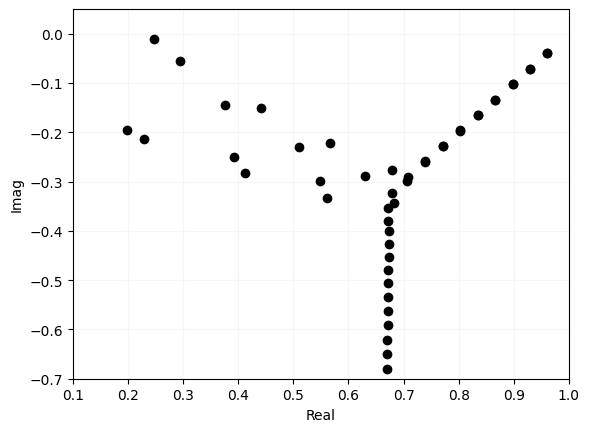

In [16]:
if args['plot']==True:
    plt.figure()
    evi = evals*z.alfa
    plt.plot(evi.real,evi.imag, 'o', c=mcolors.CSS4_COLORS['black'])
    plt.axis([0.1,1,-0.7, 0.05])
    plt.ylabel("Imag")
    plt.xlabel("Real")
    plt.grid(color=mcolors.CSS4_COLORS['whitesmoke'])
    plt.show()

We further define functions for calculating condition numbers.

In [23]:
kap = lambda A: np.linalg.norm(A) * np.linalg.norm(np.linalg.pinv(A))
con = lambda A: np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A))
cond = lambda A: np.linalg.cond(A)

def cond_number(d, N, class_name):
    cond_numbers={"A (Galerkin)":[],
    "A left preconditioned (Galerkin)":[],
    "A left and right preconditioned (Galerkin)":[],
    "A (Petrov-Galerkin)":[]
    }
    for (test, trial, ktest, ktrial,name) in d:
        for k0 in ktest:
            for k1 in ktrial:
                condA = np.zeros(len(N))
                for i, n in enumerate(N):
                    z = class_name(N=n+4, test=test, trial=trial)
                    if name=="A left preconditioned (Galerkin)":
                        A, B = z.assemble(scale=None)
                        d = (1/A.diagonal())[:, None]
                        A = d*A
                    elif name in ["A (Galerkin)","A (Petrov-Galerkin)"]:
                        A, B = z.assemble(scale=None)
                    else:
                        A, B = z.assemble(scale=(k0,k1))
                    condA[i] = cond(A)
                cond_numbers[name]=condA
                a = condA[1:]/condA[:-1]
                orderA = np.log2(a)/np.log2(N[1:]/N[:-1])               
                print(f"{test:5s} {trial:5s} {str(k0):8s} {str(k1):8s} {orderA[-1]:2.4f} {condA[-1]:2.2e}") 

    return cond_numbers  

We also define a list of tuples representing different test and trial functions. We then call the `cond_number()` function to calculate the condition numbers for different values of N using the OrrSommerfeld class.

In [18]:
d = [('G', 'G', (0,), (0,),"A left preconditioned (Galerkin)"),
     ('G', 'G', (0,), (0,),"A (Galerkin)"),
     ('PG', 'G', (0,), (0,),"A (Petrov-Galerkin)"),
     ('G', 'G', (-2,), (-2,),"A left and right preconditioned (Galerkin)")
     ]
print(f"{'Test':14s} {'Trial':14s} {'Test k^{}':8s} {'Trial k^{}':8s} {'O(N^{})'} {'cond'}")
pp = "{16s}{}"
M=11
N = 2**(np.arange(3,M))
cond_OS = cond_number(d, N, OrrSommerfeld)

Test           Trial          Test k^{} Trial k^{} O(N^{}) cond
G     G     0        0        1.4961 4.38e+03
G     G     0        0        3.9922 1.01e+09
PG    G     0        0        2.4968 1.16e+09
G     G     -2       -2       0.0029 3.58e+03


Finally, we plot the condition numbers using `matplotlib` and display the plot.

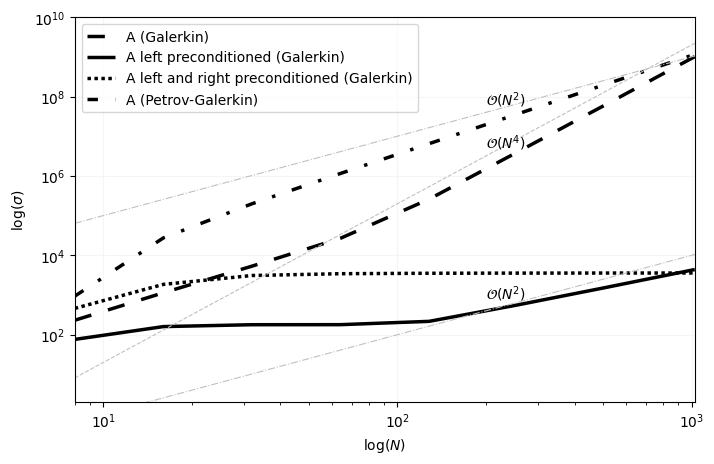

In [19]:
plt.figure(1,figsize=(8,5))
for k,v,name in zip(cond_OS.keys(),cond_OS.values(),markers):
	    plt.loglog(N, v, label=k, linestyle=linestyles[name],c=mcolors.CSS4_COLORS['black'],linewidth=2.5)
plt.loglog(N, 10**(-2.7)*(N)**4,linestyle='--',c=mcolors.CSS4_COLORS['silver'],linewidth=0.8)
plt.loglog(N, 10**3*(N)**2, linestyle='-.',c=mcolors.CSS4_COLORS['silver'],linewidth=0.8)
plt.loglog(N, 10**(-2)*(N)**2, linestyle='-.',c=mcolors.CSS4_COLORS['silver'],linewidth=0.8)
plt.annotate(r'$\mathcal{O}(N^4)$', xy=(10**2.3, 10**6.7))
plt.annotate(r'$\mathcal{O}(N^2)$', xy=(10**2.3, 10**2.9))
plt.annotate(r'$\mathcal{O}(N^2)$', xy=(10**2.3, 10**7.8))
plt.ylabel(r'$\log(\sigma)$')
plt.xlabel(r'$\log(N)$')
plt.grid(color=mcolors.CSS4_COLORS['whitesmoke'])
plt.legend(loc="upper left")
plt.axis([2**3,2**(M-1),2, 10**10])  
plt.show()

The same procedure is applicable for `OrrSommerfeldMHD`.

In [24]:
d = [('G', 'G', ((0, 0),), ((0, 0),),"A left preconditioned (Galerkin)"),
     ('G', 'G', ((0, 0),), ((0, 0),),"A (Galerkin)"),
     ('PG', 'G', ((0, 0),), ((0, 0),),"A (Petrov-Galerkin)"),
     ('G', 'G', ((-2, 0),), ((-2, 0),),"A left and right preconditioned (Galerkin)")
     ]

print(f"{'Test':14s} {'Trial':14s} {'Test k^{}':8s} {'Trial k^{}':8s} {'O(N^{})'} {'cond'}")
pp = "{16s}{}"
MM = 11
N = 2**(np.arange(3,MM))
M = 2*N+2
cond_OSMHD = cond_number(d, N, OrrSommerfeldMHD)

Test           Trial          Test k^{} Trial k^{} O(N^{}) cond
G     G     (0, 0)   (0, 0)   1.4943 4.94e+03
G     G     (0, 0)   (0, 0)   3.9922 7.02e+12
PG    G     (0, 0)   (0, 0)   2.4969 1.38e+09
G     G     (-2, 0)  (-2, 0)  0.0000 1.50e+05


The results are shown in the following figure.

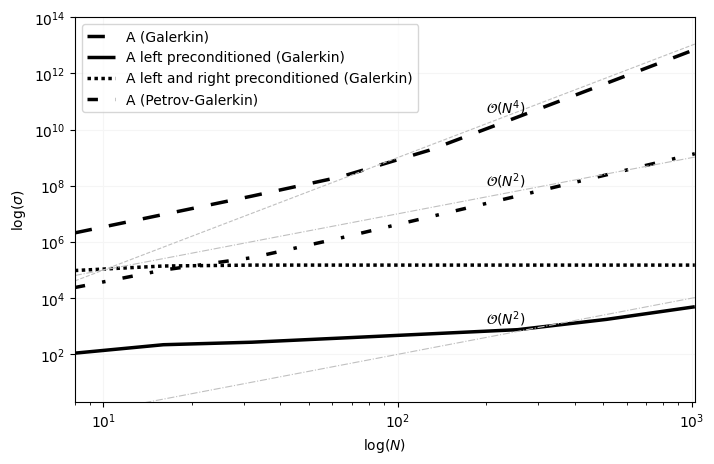

In [25]:
plt.figure(1,figsize=(8,5))
for k,v,name in zip(cond_OSMHD.keys(),cond_OSMHD.values(),markers):
	    plt.loglog(N, v, label=k, linestyle=linestyles[name],c=mcolors.CSS4_COLORS['black'],linewidth=2.5)
plt.loglog(N, 10*(N)**4,linestyle='--',c=mcolors.CSS4_COLORS['silver'],linewidth=0.8)
plt.loglog(N, 10**3*(N)**2, linestyle='-.',c=mcolors.CSS4_COLORS['silver'],linewidth=0.8)
plt.loglog(N, 10**(-2)*(N)**2, linestyle='-.',c=mcolors.CSS4_COLORS['silver'],linewidth=0.8)
plt.annotate(r'$\mathcal{O}(N^4)$', xy=(10**2.3, 10**10.6))
plt.annotate(r'$\mathcal{O}(N^2)$', xy=(10**2.3, 10**3.1))
plt.annotate(r'$\mathcal{O}(N^2)$', xy=(10**2.3, 10**8))
plt.ylabel(r'$\log(\sigma)$')
plt.xlabel(r'$\log(N)$')
plt.grid(color=mcolors.CSS4_COLORS['whitesmoke'])
plt.legend(loc="upper left")
plt.axis([2**3,2**(MM-1),2, 10**14])    
plt.show()

Please note, that the condition numbers for matrix A, left and right preconditioned (Galerkin), corresponds to $O(N^{0})$ and seem to be bounded.